# Trabalho Semestral de Aprendizado de Máquina
## Jah'Podi Pôneis

## Introdução

O objetivo desse trabalho é utilizar modelos e estratégias de aprendizado de máquina com a finalidade de prever o band gap de materiais de duas formas: 

- Utilizando como features dos modelos apenas a proporção molar dos materiais
- Utilizando como features dos modelos a proporção molar dos materiais multiplicada pelos valores de eletronegatividade dos átomos que o compôem

Queríamos saber se caso utilizássemos a eletronegatividade dos átomos que compôem esse material teríamos uma melhor predição. Essa motivação está explicada em mais detalhes no `README`. 

Para isso, vamos utilizar o dataset `expt_gap` da biblioteca `matminer`, que contém diversos materiais e suas propriedades termoelétricas, dentre elas a condutividade. Porém, precisaremos realizar algumas modificações no dataset, para que tenhamos os dois casos de features citados acima, sendo essa parte realizada no Tratamento do Dataset.

Em seguida, vamos treinar três modelos para cada caso: baseline, regressão linear e floresta aleatória. Vamos treinar os últimos dois modelos com e sem o uso de PCA para reduzir a dimensionalidade do problema. No fim desse notebook, temos uma discussão sobre os resultados obtidos e análise das hipóteses iniciais.

Abaixo estão constantes que serão usadas durante todo o notebook.

In [1]:
TAMANHO_TESTE = 0.1
SEED = 7530
NUM_FOLDS = 10
NUM_ITERACOES = 20

### Importações

Abaixo estão todas as importações que serão utilizadas ao longo do notebook.

In [2]:
import matplotlib.pyplot as plt

import numpy as np

from pymatgen.core import Composition 

from mendeleev import element

from matminer.datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Tratamento do Dataset 

Destacando-se em contextos científicos e de engenharia de materiais, o Matminer é uma biblioteca Python essencial para a trabalhar com dados na área de materiais. Oferecendo grandes datasets para serem explorados. Sua funcionalidade permite a análise eficiente de dados no caso do dataset que trabalhamos, em proporção molar.  

Primeiramente, vamos retirar as colunas que não serão utilizadas do dataframe `df`, e remover as linhas com valor `Nan`.

In [3]:
df = load_dataset("expt_gap")

df = df.dropna()

df

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44
...,...,...
6349,Tm2MgTl,0.00
6350,Nb5Ga4,0.00
6351,Tb2Sb5,0.00
6352,Lu2AlTc,0.00


Como é possível observar, nesse dataset. Nem todos os elementos estão com números inteiros. Portanto, nós fizemos uma decomposição de cada composto levando em consideração a proporção molar dos elementos. Por isso utilizamos a pymatgen e sua função para decompor as strings do dataset em um dicionário com os devidos valores proporcionais

Utilizando a função `Composition` do módulo `pymatgen.core`, vamos criar uma lista de dicicionários, `lista_dict`, em que cada chave desses dicionários são os elementos que compõem o material e seus valores são a respectiva proporção molar.

In [4]:
lista_dict = []

for string in df['formula']:
    composicao = Composition(string)
    composicao_dict = composicao.as_dict()
    lista_dict.append(composicao_dict)

Visualizando os primeiros itens dessa lista:

In [5]:
print(lista_dict[0:10])

[{'Hg': 0.7, 'Cd': 0.3, 'Te': 1.0}, {'Cu': 1.0, 'Br': 1.0}, {'Lu': 1.0, 'P': 1.0}, {'Cu': 3.0, 'Sb': 1.0, 'Se': 4.0}, {'Zn': 1.0, 'O': 1.0}, {'Pt': 1.0, 'Sb': 2.0}, {'Zn': 1.0, 'In': 2.0, 'S': 4.0}, {'K': 2.0, 'Cd': 3.0, 'Te': 4.0}, {'K': 4.0, 'Sn': 3.0, 'Ce': 3.0, 'S': 14.0}, {'Pb': 6.0, 'B': 2.0, 'Cr': 1.0, 'O': 12.0}]


Agora, vamos criar uma coluna para cada elemento químico que foi utilizado nos materiais do dataset, inicialmente contendo apenas valores iguais a zero. 

In [6]:
for dicionario in lista_dict: 
    for chave in dicionario:
        df[chave] = np.zeros(len(lista_dict))

Em seguida, vamos adicionar os valores de proporção molar nas novas colunas criadas no `df`. Para não ocorrer problema de sobrescrição de valores, vamos utilizar o método `df.loc` do `pandas`, que evita esse problema.  

In [7]:
for indice, dicionario in enumerate(lista_dict): 
    for chave in dicionario:
        df.loc[indice, chave] = dicionario[chave]
        
df = df.dropna()

df = df.drop('G0+', axis=1)

df

,formula,gap expt,Hg,Cd,Te,Cu,Br,Lu,P,Sb,...,Co,Nd,Ho,C,Rh,Ni,Tc,Re,Pm,Xe
0,Hg0.7Cd0.3Te,0.35,0.7,0.3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CuBr,3.08,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LuP,1.30,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cu3SbSe4,0.40,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZnO,3.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6349,Tm2MgTl,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6350,Nb5Ga4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6351,Tb2Sb5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6352,Lu2AlTc,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


O próximo passo é criar as colunas que vão conter a proporção molar multiplicada pelo valor da eletronegatividade de cada átomo. Primeiro, vamos criar uma lista, `lista_elementos`, com todos os elementos químicos presentes no dataset. 

In [8]:
lista_elementos = []

for coluna in df:
    lista_elementos.append(coluna)
    
lista_elementos.remove('formula') 
lista_elementos.remove('gap expt')

Visualizando essa lista:

In [9]:
print(lista_elementos)

['Hg', 'Cd', 'Te', 'Cu', 'Br', 'Lu', 'P', 'Sb', 'Se', 'Zn', 'O', 'Pt', 'In', 'S', 'K', 'Sn', 'Ce', 'Pb', 'B', 'Cr', 'Sr', 'Be', 'Nb', 'Pr', 'As', 'Ba', 'Ga', 'Ge', 'Ag', 'Rb', 'Th', 'Tl', 'Al', 'Bi', 'Au', 'Cs', 'H', 'Si', 'N', 'Gd', 'Sc', 'Mn', 'La', 'F', 'Cl', 'I', 'W', 'Eu', 'Yb', 'Tm', 'Sm', 'Na', 'Mo', 'V', 'U', 'Ta', 'Pd', 'Tb', 'Ca', 'Zr', 'Er', 'Hf', 'Y', 'Mg', 'Li', 'Os', 'Ru', 'Ti', 'Fe', 'Dy', 'Ir', 'Co', 'Nd', 'Ho', 'C', 'Rh', 'Ni', 'Tc', 'Re', 'Pm', 'Xe']


A seguir, utilizamos mais uma das nossas poderosas bibliotecas a fim de obter a propriedade de eletronegatividade dos elementos. Pra isso, utilizamos a biblioteca mendeleev que contém informações da Eletronegatividade de Pauling que é uma escala que atribui valores numéricos aos elementos com base em suas propriedades químicas. Quanto maior o valor de eletronegatividade de um átomo, maior sua afinidade por elétrons.

Em seguida, vamos criar uma lista, `lista_en`, que contém os valores de eletronegatividade de cada átomo, com o método `element.en_pauling` do objeto `element` do módulo `mendeleev`. 

In [10]:
lista_en = [element(elemento).en_pauling for elemento in lista_elementos]

lista_en[79] = 1.13
lista_en[47] = 1.2
lista_en[48] = 1.1
lista_en[57] = 1.2

Os elementos `Eu`, `Pm`, `Yb` e `Tb` possuiam valor de eletronegatividade `None` segundo o módulo `mendeleev`, porém pesquisamos na Wikipedia os seus respectivos valores, e adicionamos eles manualmente. 

Por fim, criamos um dicionário, `dict_en`, que une as duas listas acima, sendo a chave um elemento químico e seu respectivo valor de eletronegatividade na escala de Pauling.

In [11]:
dict_en = {}

for i in range(len(lista_elementos)):
    dict_en.update({lista_elementos[i]:lista_en[i]})
    
print(dict_en)

{'Hg': 1.9, 'Cd': 1.69, 'Te': 2.1, 'Cu': 1.9, 'Br': 2.96, 'Lu': 1.0, 'P': 2.19, 'Sb': 2.05, 'Se': 2.55, 'Zn': 1.65, 'O': 3.44, 'Pt': 2.2, 'In': 1.78, 'S': 2.58, 'K': 0.82, 'Sn': 1.96, 'Ce': 1.12, 'Pb': 1.8, 'B': 2.04, 'Cr': 1.66, 'Sr': 0.95, 'Be': 1.57, 'Nb': 1.6, 'Pr': 1.13, 'As': 2.18, 'Ba': 0.89, 'Ga': 1.81, 'Ge': 2.01, 'Ag': 1.93, 'Rb': 0.82, 'Th': 1.3, 'Tl': 1.8, 'Al': 1.61, 'Bi': 1.9, 'Au': 2.4, 'Cs': 0.79, 'H': 2.2, 'Si': 1.9, 'N': 3.04, 'Gd': 1.2, 'Sc': 1.36, 'Mn': 1.55, 'La': 1.1, 'F': 3.98, 'Cl': 3.16, 'I': 2.66, 'W': 1.7, 'Eu': 1.2, 'Yb': 1.1, 'Tm': 1.25, 'Sm': 1.17, 'Na': 0.93, 'Mo': 2.16, 'V': 1.63, 'U': 1.7, 'Ta': 1.5, 'Pd': 2.2, 'Tb': 1.2, 'Ca': 1.0, 'Zr': 1.33, 'Er': 1.24, 'Hf': 1.3, 'Y': 1.22, 'Mg': 1.31, 'Li': 0.98, 'Os': 2.2, 'Ru': 2.2, 'Ti': 1.54, 'Fe': 1.83, 'Dy': 1.22, 'Ir': 2.2, 'Co': 1.88, 'Nd': 1.14, 'Ho': 1.23, 'C': 2.55, 'Rh': 2.28, 'Ni': 1.91, 'Tc': 2.1, 'Re': 1.9, 'Pm': 1.13, 'Xe': 2.6}


Finalmente, vamos criar as colunas que contém a proporção molar do material multiplicado pelo valor de eletronegaticidade de cada átomo de sua estrutura.

In [12]:
for coluna in df:
    if coluna != 'formula' and coluna != 'gap expt':
        df[f'{coluna}_en'] = df[coluna] * dict_en[coluna]
        
df

,formula,gap expt,Hg,Cd,Te,Cu,Br,Lu,P,Sb,...,Co_en,Nd_en,Ho_en,C_en,Rh_en,Ni_en,Tc_en,Re_en,Pm_en,Xe_en
0,Hg0.7Cd0.3Te,0.35,0.7,0.3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CuBr,3.08,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LuP,1.30,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cu3SbSe4,0.40,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZnO,3.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6349,Tm2MgTl,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6350,Nb5Ga4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6351,Tb2Sb5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6352,Lu2AlTc,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.1,0.0,0.0,0.0


Vamos agora separar os dois conjuntos de features que serão utilizados nos Casos 1 e 2: `FEATURE1` contém apenas a proporção molar do material, e `FEATURE2` contém a proporção molar multiplicada pela eletronegatividade, assim como o `TARGET`, que será o valor de condutividade de cada material, `sigma [S/cm]`.

In [13]:
FEATURES1 = lista_elementos 
FEATURES2 = [f'{elemento}_en' for elemento in lista_elementos]
TARGET = ['gap expt'] 

## Caso 1

Nesse caso vamos utilizar apenas a proporção molar dos materiais como features. Todas as variáveis nessa seção vão conter 1 no final, para facilitar a diferenciação das variáveis do Caso 2, que serão diferentes apenas por conta dos features diferentes.

Todos os modelos vão utilizar a normalização padrão dos features, tanto no caso 1 quanto no caso 2, para uniformizar a proporção molar em ambos os casos. 

### Train-Test Split

Realizando a separação de treino e teste com `TAMANHO_TESTE=0.1`.

In [14]:
df1 = df.copy()

df1 = df1.reindex(FEATURES1 + TARGET, axis=1)
df1 = df1.dropna()  

x1 = df1.reindex(FEATURES1, axis=1)
y1 = df1.reindex(TARGET, axis=1)

x1 = x1.values 
y1 = y1.values.ravel()

x_treino1, x_teste1, y_treino1, y_teste1 = train_test_split(
    x1, y1, test_size=TAMANHO_TESTE, random_state=SEED
)

### Modelo Baseline

Para termos uma noção se nossos modelos estão minimamente aceitáveis vamos utilizar o modelo baseline, `dummy`,  que simplesmente vai predizer a média dos valores de condutividade dos dados de treino.

In [15]:
dummy1 = make_pipeline(
    StandardScaler(),
    DummyRegressor(),
) 

dummy1.fit(x_treino1, y_treino1)
y_dummy1 = dummy1.predict(x_teste1)
rmse_dummy1 = mean_squared_error(y_dummy1, y_teste1, squared=False)

print(f'O RMSE do modelo baseline foi de {rmse_dummy1}')

O RMSE do modelo baseline foi de 1.7078501743185281


### PCA

Primeiro, vamos realizar PCA nos dados `x1` para reduzirmos a dimensionalidade do problema, mantendo 90% da variância do dataset original. O código abaixo foi retirado do notebook "8 - Seleção de atributos.ipynb" de aprendizado de máquina.

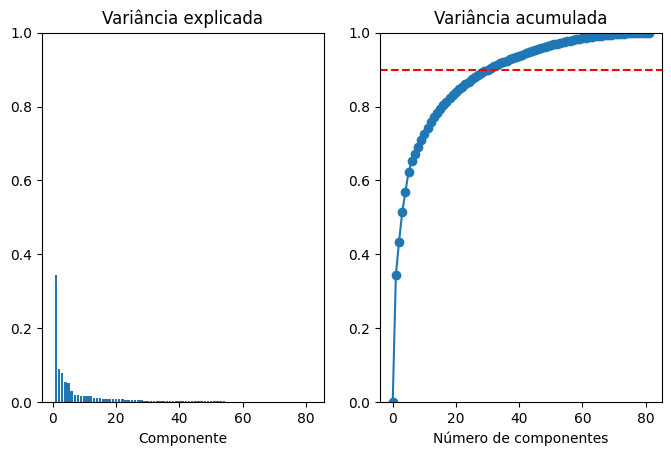

In [16]:
pca1 = PCA()

pca1.fit(x1)

autovalores1 = pca1.explained_variance_
autovetores1 = pca1.components_.T

variancia_explicada1 = pca1.explained_variance_ratio_

id_componentes1 = np.arange(1, pca1.n_components_ + 1)

figura1, eixos1 = plt.subplots(1, 2)

eixos1[0].bar(id_componentes1, variancia_explicada1)
eixos1[0].set(xlabel="Componente", title="Variância explicada", ylim=(0.0, 1.0))

cv1 = np.cumsum(pca1.explained_variance_ratio_)
eixos1[1].plot(np.r_[0, id_componentes1], np.r_[0, cv1], marker="o")
eixos1[1].set(
    xlabel="Número de componentes",
    title="Variância acumulada",
    ylim=(0.0, 1.0),
)
eixos1[1].axhline(0.9, linestyle="--", color="red")

figura1.set(figwidth=8)
plt.show()

In [17]:
print(f'O número de PCs necessárias para termos mais que 0.9 de variância acumulada é :{len(cv1)-sum(cv1>0.9)}')

O número de PCs necessárias para termos mais que 0.9 de variância acumulada é :30


Para obtermos uma variância acumulada maior que 0.9, precisamos usar `NUM_COMPONENTES1=30`, nesse caso. 

### Regressão Linear com PCA

Treinando um modelo de regressão linear aliado ao PCA, com ajuda da função `make_pipeline`:

In [42]:
NUM_COMPONENTES1 = 30

linear_regression_pca1 = make_pipeline(
    StandardScaler(),
    PCA(NUM_COMPONENTES1),
    LinearRegression(),
) 

linear_regression_pca1.fit(x_treino1, y_treino1)
y_linear_regression_pca1 = linear_regression_pca1.predict(x_teste1)
rmse_linear_regression_pca1 = mean_squared_error(y_linear_regression_pca1, y_teste1, squared=False)

print(f'O RMSE do modelo de regressão linear com PCA foi de {rmse_linear_regression_pca1}')

O RMSE do modelo de regressão linear com PCA foi de 1.6557109123179221


### Regressão Linear com PCA

Treinando um modelo de regressão linear sem PCA:

In [53]:
linear_regression1 = make_pipeline(
    StandardScaler(),
    LinearRegression()
) 

linear_regression1.fit(x_treino1, y_treino1)
y_linear_regression1 = linear_regression1.predict(x_teste1)
rmse_linear_regression1 = mean_squared_error(y_linear_regression1, y_teste1, squared=False)

print(f'O RMSE do modelo de regressão linear sem PCA foi de {rmse_linear_regression1}')

O RMSE do modelo de regressão linear sem PCA foi de 1.6074312470681722


### Floresta Aleatória com PCA

Relizando a otimização de hiperparâmetros com a busca aleatória, pois temos muitas possibilidades de conjuntos de hiperparâmetros:

In [28]:
random_forest1 = RandomForestRegressor(random_state=SEED)

grid_random_forest1 = {
    'max_depth': [None, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30]
}

search_random_forest1 = RandomizedSearchCV(
    random_forest1,
    grid_random_forest1,
    n_iter=NUM_ITERACOES,
    cv=NUM_FOLDS,
    scoring="neg_root_mean_squared_error",
    refit=True, 
    n_jobs=4,
    random_state=SEED
)

search_random_forest1.fit(x_treino1, y_treino1)
best_params_random_forest1 = search_random_forest1.best_params_

print('Os melhors hiperparâmetros encontrados para a floresta aleatória foram:')
print(best_params_random_forest1)
print()
print(f'O melhor modelo teve RMSE de {-search_random_forest1.best_score_}')

Os melhors hiperparâmetros encontrados para a floresta aleatória foram:
{'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_depth': None}

O melhor modelo teve RMSE de 0.9065145969390921


Treinando o modelo com os melhores hiperparâmetros com todos os dados de treino, e realizando PCA: 

In [ ]:
random_forest_otimizado_pca1 = make_pipeline(
    StandardScaler(),
    PCA(NUM_COMPONENTES1),
    RandomForestRegressor(
        max_depth = best_params_random_forest1['max_depth'],
        min_samples_leaf = best_params_random_forest1['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest1['max_leaf_nodes'],
        random_state=SEED
    )
) 

random_forest_otimizado_pca1.fit(x_treino1, y_treino1)
y_random_forest_pca1 = random_forest_otimizado_pca1.predict(x_teste1)
rmse_random_forest_pca1 = mean_squared_error(y_random_forest_pca1, y_teste1, squared=False)

print(f'O RMSE do modelo de floresta aleatória com PCA foi de {rmse_random_forest_pca1}')

O RMSE do modelo de floresta aleatória com PCA foi de 1.1792616837760732


### Floresta Aleatória sem PCA

Treinando a floresta com os melhores hiperparâmetros, mas sem o uso de PCA:

In [48]:
random_forest_otimizado1 = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(
        max_depth = best_params_random_forest1['max_depth'],
        min_samples_leaf = best_params_random_forest1['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest1['max_leaf_nodes'],
        random_state=SEED
    )
) 

random_forest_otimizado1.fit(x_treino1, y_treino1)
y_random_forest1 = random_forest_otimizado1.predict(x_teste1)
rmse_random_forest1 = mean_squared_error(y_random_forest1, y_teste1, squared=False)

print(f'O RMSE do modelo de floresta aleatória sem PCA foi de {rmse_random_forest1}')

O RMSE do modelo de floresta aleatória sem PCA foi de 0.9431360064101797


## Caso 2

Nesse caso vamos utilizar a proporção molar dos materiais multiplicada pela valor de eletronegatividade como features. Todas as variáveis contém 2 no final, para diferenciar do Caso 1.

Os códigos são idênticos ao Caso 1, exceto pela mudança nos features.

### Train-Test Split

Realizando a separação de treino e teste com `TAMANHO_TESTE=0.1`.

In [21]:
df2 = df.copy()

df2 = df2.reindex(FEATURES2 + TARGET, axis=1)
df2 = df2.dropna()  

x2 = df2.reindex(FEATURES2, axis=1)
y2 = df2.reindex(TARGET, axis=1)

x2 = x2.values 
y2 = y2.values.ravel()

x_treino2, x_teste2, y_treino2, y_teste2 = train_test_split(
    x2, y2, test_size=TAMANHO_TESTE, random_state=SEED
)

### Modelo Baseline

Treinando o modelo baseline:

In [22]:
dummy2 = make_pipeline(
    StandardScaler(),
    DummyRegressor(),
) 

dummy2.fit(x_treino2, y_treino2)
y_dummy2 = dummy2.predict(x_teste2)
rmse_dummy2 = mean_squared_error(y_dummy2, y_teste2, squared=False)

print(f'O RMSE do modelo baseline foi de {rmse_dummy2}')

O RMSE do modelo baseline foi de 1.7078501743185281


### PCA

Primeiro, vamos realizar PCA nos dados `x2` para reduzirmos a dimensionalidade do problema, mantendo 90% da variância do dataset original. 

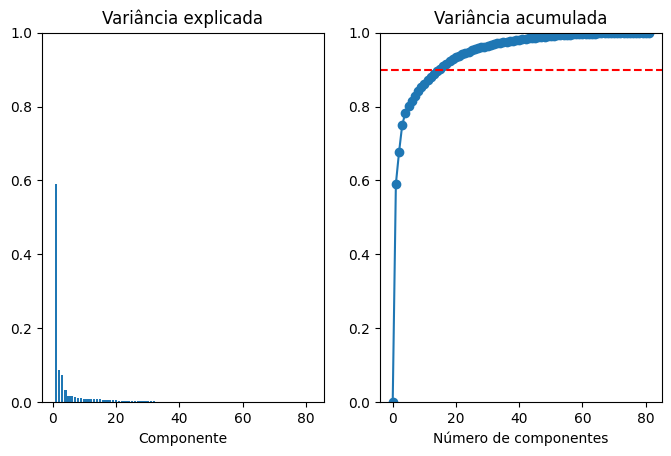

In [49]:
pca2 = PCA()

pca2.fit(x2)

autovalores2 = pca2.explained_variance_
autovetores2 = pca2.components_.T

variancia_explicada2 = pca2.explained_variance_ratio_

id_componentes2 = np.arange(1, pca2.n_components_ + 1)

figura2, eixos2 = plt.subplots(1, 2)

eixos2[0].bar(id_componentes2, variancia_explicada2)
eixos2[0].set(xlabel="Componente", title="Variância explicada", ylim=(0.0, 1.0))

cv2 = np.cumsum(pca2.explained_variance_ratio_)
eixos2[1].plot(np.r_[0, id_componentes2], np.r_[0, cv2], marker="o")
eixos2[1].set(
    xlabel="Número de componentes",
    title="Variância acumulada",
    ylim=(0.0, 1.0),
)
eixos2[1].axhline(0.9, linestyle="--", color="red")

figura2.set(figwidth=8)
plt.show()

In [50]:
print(f'O número de PCs necessárias para termos mais que 0.9 de variância acumulada é :{len(cv2)-sum(cv2>0.9)}')

O número de PCs necessárias para termos mais que 0.9 de variância acumulada é :14


Para obtermos uma variância acumulada maior que 0.9, precisamos usar `NUM_COMPONENTES2=14`, nesse caso. 

### Regressão Linear com PCA

Treinando um modelo de regressão linear aliado ao PCA, com ajuda da função `make_pipeline`:

In [52]:
NUM_COMPONENTES2 = 14

linear_regression_pca2 = make_pipeline(
    StandardScaler(),
    PCA(NUM_COMPONENTES2),
    LinearRegression(),
) 

linear_regression_pca2.fit(x_treino2, y_treino2)
y_linear_regression_pca2 = linear_regression_pca2.predict(x_teste2)
rmse_linear_regression_pca2 = mean_squared_error(y_linear_regression_pca2, y_teste2, squared=False)

print(f'O RMSE do modelo de regressão linear com PCA foi de {rmse_linear_regression_pca2}')

O RMSE do modelo de regressão linear com PCA foi de 1.6837870343945067


### Regressão Linear com PCA

Treinando um modelo de regressão linear sem PCA:

In [54]:
linear_regression2 = make_pipeline(
    StandardScaler(),
    LinearRegression()
) 

linear_regression2.fit(x_treino2, y_treino2)
y_linear_regression2 = linear_regression2.predict(x_teste2)
rmse_linear_regression2 = mean_squared_error(y_linear_regression2, y_teste2, squared=False)

print(f'O RMSE do modelo de regressão linear sem PCA foi de {rmse_linear_regression2}')

O RMSE do modelo de regressão linear sem PCA foi de 1.607431247068172


### Floresta Aleatória com PCA

Relizando a otimização de hiperparâmetros com a busca aleatória, pois temos muitas possibilidades de conjuntos de hiperparâmetros:

In [55]:
random_forest2 = RandomForestRegressor(random_state=SEED)

grid_random_forest2 = {
    'max_depth': [None, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30]
}

search_random_forest2 = RandomizedSearchCV(
    random_forest2,
    grid_random_forest2,
    n_iter=NUM_ITERACOES,
    cv=NUM_FOLDS,
    scoring="neg_root_mean_squared_error",
    refit=True, 
    n_jobs=4,
    random_state=SEED
)

search_random_forest2.fit(x_treino2, y_treino2)
best_params_random_forest2 = search_random_forest2.best_params_

print('Os melhors hiperparâmetros encontrados para a floresta aleatória foram:')
print(best_params_random_forest2)
print()
print(f'O melhor modelo teve RMSE de {-search_random_forest2.best_score_}')

Os melhors hiperparâmetros encontrados para a floresta aleatória foram:
{'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_depth': None}

O melhor modelo teve RMSE de 0.9044473146817584


Treinando o modelo com os melhores hiperparâmetros com todos os dados de treino, e realizando PCA: 

In [56]:
random_forest_otimizado_pca2 = make_pipeline(
    StandardScaler(),
    PCA(NUM_COMPONENTES2),
    RandomForestRegressor(
        max_depth = best_params_random_forest2['max_depth'],
        min_samples_leaf = best_params_random_forest2['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest2['max_leaf_nodes'],
        random_state=SEED
    )
) 

random_forest_otimizado_pca2.fit(x_treino2, y_treino2)
y_random_forest_pca2 = random_forest_otimizado_pca2.predict(x_teste2)
rmse_random_forest_pca2 = mean_squared_error(y_random_forest_pca2, y_teste2, squared=False)

print(f'O RMSE do modelo de floresta aleatória com PCA foi de {rmse_random_forest_pca2}')

O RMSE do modelo de floresta aleatória com PCA foi de 1.3044624278579706


### Floresta Aleatória sem PCA

Treinando a floresta com os melhores hiperparâmetros, mas sem o uso de PCA:

In [57]:
random_forest_otimizado2 = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(
        max_depth = best_params_random_forest2['max_depth'],
        min_samples_leaf = best_params_random_forest2['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest2['max_leaf_nodes'],
        random_state=SEED
    )
) 

random_forest_otimizado2.fit(x_treino2, y_treino2)
y_random_forest2 = random_forest_otimizado2.predict(x_teste2)
rmse_random_forest2 = mean_squared_error(y_random_forest2, y_teste2, squared=False)

print(f'O RMSE do modelo de floresta aleatória sem PCA foi de {rmse_random_forest2}')

O RMSE do modelo de floresta aleatória sem PCA foi de 0.9431360064101797


Realizando PCA nos dados `x2` para reduzirmos a dimensionalidade do problema. 

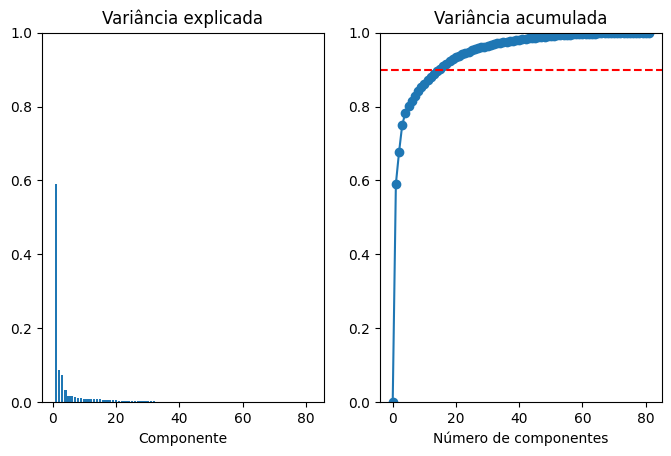

In [23]:
pca2 = PCA()

pca2.fit(x2)

autovalores2 = pca2.explained_variance_
autovetores2 = pca2.components_.T

variancia_explicada2 = pca2.explained_variance_ratio_

id_componentes2 = np.arange(1, pca2.n_components_ + 1)

figura2, eixos2 = plt.subplots(1, 2)

eixos2[0].bar(id_componentes2, variancia_explicada2)
eixos2[0].set(xlabel="Componente", title="Variância explicada", ylim=(0.0, 1.0))

cv2 = np.cumsum(pca2.explained_variance_ratio_)
eixos2[1].plot(np.r_[0, id_componentes2], np.r_[0, cv2], marker="o")
eixos2[1].set(
    xlabel="Número de componentes",
    title="Variância acumulada",
    ylim=(0.0, 1.0),
)
eixos2[1].axhline(0.9, linestyle="--", color="red")

figura2.set(figwidth=8)
plt.show()

In [24]:
print(f'O número de PCs necessárias para termos mais que 0.9 de variância acumulada é :{len(cv2)-sum(cv2>0.9)}')

O número de PCs necessárias para termos mais que 0.9 de variância acumulada é :14


Para obtermos uma variância acumulada maior que 0.9, precisamos usar `num_componentes2=14`, nesse caso. 

Treinando o modelo de regressão linear:

In [25]:
num_componentes2 = 14

linear_regression2 = make_pipeline(
    StandardScaler(),
    PCA(num_componentes2),
    LinearRegression(),
) 

linear_regression2.fit(x_treino2, y_treino2)
y_linear_regression2 = linear_regression2.predict(x_teste2)
rmse_linear_regression2 = mean_squared_error(y_linear_regression2, y_teste2, squared=False)

print(f'O RMSE do modelo de regressão linear com PCA foi de {rmse_linear_regression2}')

O RMSE do modelo de regressão linear com PCA foi de 1.675806950504875


Otimizando os hiperparâmetros da floresta aleatória:

In [26]:
random_forest2 = RandomForestRegressor(random_state=SEED)

grid_random_forest2 = {
    'max_depth': [None, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30]
}

search_random_forest2 = RandomizedSearchCV(
    random_forest2,
    grid_random_forest2,
    n_iter=NUM_ITERACOES,
    cv=NUM_FOLDS,
    scoring="neg_root_mean_squared_error",
    refit=True, 
    n_jobs=4,
    random_state=SEED
)

search_random_forest2.fit(x_treino2, y_treino2)
best_params_random_forest2 = search_random_forest2.best_params_

print('Os melhors hiperparâmetros encontrados para a floresta aleatória foram:')
print(best_params_random_forest2)
print()
print(f'O melhor modelo teve RMSE de {-search_random_forest2.best_score_}')

Os melhors hiperparâmetros encontrados para a floresta aleatória foram:
{'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_depth': None}

O melhor modelo teve RMSE de 0.9044473146817584


Treinando o modelo com os melhores hiperparâmetros e com todos os dados de treino: 

In [27]:
random_forest_otimizado2 = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(
        max_depth = best_params_random_forest2['max_depth'],
        min_samples_leaf = best_params_random_forest2['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest2['max_leaf_nodes'],
        random_state=SEED
    )
) 

random_forest_otimizado2.fit(x_treino2, y_treino2)
y_random_forest2 = random_forest_otimizado2.predict(x_teste2)
rmse_random_forest2 = mean_squared_error(y_random_forest2, y_teste2, squared=False)

print(f'O RMSE do modelo de floresta aleatória foi de {rmse_random_forest2}')

O RMSE do modelo de floresta aleatória foi de 0.9431360064101797


## Resultados e Discussão 

In [60]:
print(f'O modelo de regressão linear obteve performances no caso 1 de: {rmse_linear_regression1} sem PCA e {rmse_linear_regression_pca1} com PCA')
print(f'O modelo de regressão linear obteve performances no caso 2 de: {rmse_linear_regression2} sem PCA e {rmse_linear_regression_pca2} com PCA')
print()
print(f'O modelo de floresta aleatória obteve performances no caso 1 de: {rmse_random_forest1} sem PCA e {rmse_random_forest_pca1} com PCA')
print(f'O modelo de floresta aleatória obteve performances no caso 2 de: {rmse_random_forest2} sem PCA e {rmse_random_forest_pca2} com PCA')

O modelo de regressão linear obteve performances no caso 1 de: 1.6074312470681722 sem PCA e 1.6557109123179221 com PCA
O modelo de regressão linear obteve performances no caso 2 de: 1.607431247068172 sem PCA e 1.6837870343945067 com PCA

O modelo de floresta aleatória obteve performances no caso 1 de: 0.9431360064101797 sem PCA e 1.1792616837760732 com PCA
O modelo de floresta aleatória obteve performances no caso 2 de: 0.9431360064101797 sem PCA e 1.3044624278579706 com PCA


Primeiramente, podemos observar que ambos os modelos de regressão linear e floresta aleatória obtiveram a mesma performance nos casos 1 e 2. Isso reflete que a eletronegatividade dos átomos não trouxe nenhuma informação nova para a predição dos valores de band gap dos materiais. 

Outro fato que podemos destacar é que todos os modelos pioraram após a redução de dimensionalidade feita após o PCA. Os modelos lineares perderam pouca performance, porém, as florestas aleatórias pioraram muito sua performance após o PCA. Isso pode significar que a perda da informação durante a redução de dimensionalidade tenha afetado negativamente os modelos, talvez pela forma por como o dataset foi construído. Porém, um fato curioso é de que no caso 1, precisamos de 30 PCs para obtermos 90% de variância total dos features iniciais, enquanto no caso 2 precisamos apenas de 14 PCs, ou seja, de alguma forma a eletronegatividade pode ter ajudado a agrupar mais informação após o PCA.

Por fim, podemos ver que o modelo de floresta aleatória foi o melhor modelo, independente do caso ou do uso ou não de PCA, em relação ao modelos lineares. Dessa forma, podemos concluir que a relação de proporção molar e eletronegatividade dos materiais com o band gap não é linear. Como as florestas aleatórias são compostas de árvores de decisão, elas conseguem repartir os dados em subespaços, sendo muito boas em capturar relações que são extremamente complexas entre os features e o target. 

## Conclusão

Após a análise dos resultados, concluímos que dados os modelos e estratégias utilizadas, a eletronegatividade dos átomos não melhorou a predição dos valores de band gap de materiais semicondutores. Também concluímos que a relação da proporção molar (junto ou não da eletronegatividade) dos elementos químicos presentes em um material é melhor previsto pelo modelo de floresta aleatória, não possuindo uma relação linear entre essas duas grandezas.

Para futuros trabalhos poderíamos explorar outros features que influenciem no band gap de um material, que agregassem mais informação para os modelos de florestas aleatórias. Outro ponto que poderia ser explorado é a diferença de variância acumulada após o PCA dos dois casos, e explorar se caso a eletronegatividade dos átomos não poderia ser utilizada de outra forma nesses modelos, ou se realmente essa hipótese é grosseira demais para se traduzir em alguma predição confiável.

## Referências

- https://hackingmaterials.lbl.gov/matminer/ (documentação do `matminer`)
- https://pymatgen.org/ (documentação do `pymatgen`)
- https://pypi.org/project/mendeleev/ (documentação do `mendeleev`)
- https://hackingmaterials.lbl.gov/matminer/dataset_summary.html#ucsb-thermoelectrics (página do dataset `ucsb_thermoelectrics`)
- https://pt.wikipedia.org/wiki/It%C3%A9rbio (eletronegatividade do Yb)
- https://pt.wikipedia.org/wiki/T%C3%A9rbio (eletronegatividade do Tb)
- https://en.wikipedia.org/wiki/Europium (eletronegatividade do Eu)
- https://pt.wikipedia.org/wiki/Prom%C3%A9cio (eletronegatividade do Pm)
- Notebook "8 - Seleção de atributos.ipynb" da disciplina de aprendizado de máquina